In [83]:
import numpy as np
from matplotlib import pyplot as plt
from matplotlib import animation
from scipy.integrate import solve_ivp

In [84]:
import importlib
import sys
from pathlib import Path
import os 
sys.path.append(str(Path(os.getcwd()).parent / "src"))

import active_gel
importlib.reload(active_gel)

<module 'active_gel' from '/Users/yuli/Documents/Code/Cleavage/src/active_gel.py'>

In [139]:
class stress_gel_2d(active_gel.ActiveGel2D):


    def evolve(self):
        # The core function that integrates the ODEs forward. 
        t_span = np.linspace(0, self.T, self.n_frames)
        self.res = solve_ivp(self._rhs, (0, self.T), self.initial_state, t_eval=t_span, method='RK45', rtol=1e-5)
        evo = self.res.y.reshape((3, self.L, self.L, self.n_frames))
        self.Q, self.q, self.rho = np.rollaxis(evo, -1, 1)
        self.v = list(map(self._solve_for_v, t_span, self.rho, self.Q, self.q))

    def _set_M(self):
        k = np.fft.fftfreq(self.L)*2*np.pi
        kx, ky = np.meshgrid(k, k, indexing='ij')
        Mxx = (self.eta0+self.eta1)*kx*kx + self.eta0*ky*ky + self.gamma # compression, screened by friction  
        Mxy = self.eta1*kx*ky  
        Myy = (self.eta0+self.eta1)*ky*ky + self.eta0*kx*kx + self.gamma # compression, screened by friction 
        A = np.stack([Mxx, Mxy, Mxy, Myy], axis=-1).reshape((self.L, self.L, 2, 2)).astype('complex')
        self.M = - np.linalg.inv(A)
        self.ik = 1j*np.stack([kx, ky], axis=-1)

    def _solve_for_v(self, t, rho, Q, q): 
        P = self.xi*rho*2/(1+rho)*self.source(t) 
        Pk = np.fft.fft2(P)
        
        Qk = np.fft.fft2(Q*rho*self.source(t))
        qk = np.fft.fft2(q*rho*self.source(t)) 
        
        # coupling, ik P + ik_j Q_{ij} 
        
        t1 = self.ik*Pk[:, :, np.newaxis]
        t2 = self.ik[:, :, 0]*Qk + self.ik[:, :, 1]*qk 
        t3 = self.ik[:, :, 0]*qk - self.ik[:, :, 1]*Qk
        t4 = self.zeta*np.stack([t2, t3], axis=(-1))
        
        vk = np.einsum('ijkl,ijl->ijk', self.M, (t1+t4))
        vx = np.fft.ifft2(vk[:, :, 0]).real
        vy = np.fft.ifft2(vk[:, :, 1]).real
        
        t1 = np.einsum('ij,kl->ijkl', Pk, np.identity(2))
        t2 = self.zeta*self._Q_matrix(Qk, qk)
        t = np.fft.ifft2(-t1-t2, axes=(0, 1)).real
        return vx, vy, t
    
    def _strain_rate(self, vk): 
        vxy = np.einsum('imj,imk->imjk', self.ik, vk)
        trace = np.einsum('imkk->im', vxy)
        compression = np.einsum('ij,kl->ijkl', trace, np.identity(2))
        vxy -= compression/2
        return self.eta0*vxy + self.eta1*compression
    
    def _Q_matrix(self, Q, q): 
        return np.stack([Q, q, q, -Q], axis=-1).reshape((self.L, self.L, 2, 2))
    
    def _rhs(self, t, y):
        Q, q, rho = y.reshape((3, self.L, self.L))
        
        # solve for v
        vx, vy, t = self._solve_for_v(t, rho, Q, q)
        
        vxx = self._dx(vx)
        vyy = self._dy(vy)
        vxy = self._dx(vy)
        vyx = self._dy(vx)
        exy = (vxy + vyx)/2
        lapQ = self._laplacian(Q)
        lapq = self._laplacian(q)

        # rho equation 
        t_trace = np.einsum('ijkk->ij', t)
        tQ = t[:, :, 0, 0] - t_trace[:, :]/2 
        tq = t[:, :, 1, 0]
        
        drho = self._mass_flow(vx, vy, rho) - self.k*rho*(rho-1) + self._laplacian(rho)
        
        # Q equations 
        dQ = self.b1/2*(vxx - vyy) -self.chi/self.b2*np.sign(tQ)*Q*(Q-np.tanh(tQ/0.2)) + self.kappa/self.b2*lapQ # force 
        dq = self.b1*exy -self.chi/self.b2*np.sign(tq)*q*(q-np.tanh(tq/0.2)) + self.kappa/self.b2*lapq 
        dQ -= self._advection(vx, Q, 0) + self._advection(vy, Q, 1) + (vxy-vyx)/2*q # co derivatives 
        dq -= self._advection(vx, q, 0) + self._advection(vy, q, 1) - (vxy-vyx)*Q
        return np.stack([dQ, dq, drho]).flatten()
    
def nematic_to_xy(Q, q):
    theta = np.arctan2(-q, Q)
    A = np.sqrt(Q**2 + q**2)
    return A*np.cos(theta/2), A*np.sin(theta/2)

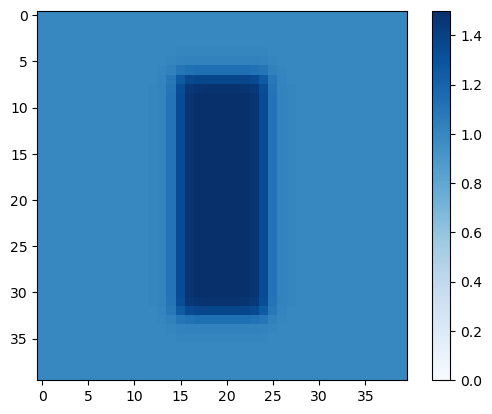

In [141]:
# b1 = 1 # nematic coupling to velocity 
# b2 = 15 # motility/diffusion constant 
# chi = 1 # parameter of the free energy 
# kappa = 0.1  # parameter of the free energy 
# etas = [1, 0] # eta0: viscosity, eta1: compressibility (compressibility doesn't matter in 1D)
# xi =  0.1 # contractility of actin
# zeta = 0.5  # contribution of nematic order to active stress 
# k = 0.1 # density decay rate 
# gamma = 0.1 # friction 


b1 = 1 # nematic coupling to velocity 
b2 = 10 # motility/diffusion constant 
chi = 1 # parameter of the free energy 
kappa = 1 # parameter of the free energy 
etas = [1, 0] # eta0: viscosity , eta1: compressibility
xi = -0.1 # contractility of actin
zeta = -0.3 # contribution of nematic order to active stress 
k = 0.1 # density decay rate 
gamma = 0.1 # friction 

L = 40
T = 50
n_frames = int(T)

init = np.zeros((L*L*3))
init[:L*L] = np.random.normal(scale=0.1, size=L*L)
init[-L*L:] = np.random.normal(scale=0.1, size=L*L)+1

indices = np.linspace(0, L, L) - L/2 
y, x = np.meshgrid(indices, indices)

source = lambda t: np.ones((L, L)) + 0.5*(1 - np.tanh((np.abs(x)-(L/8))))/2*(1 - np.tanh((np.abs(y)-(L/3))))/2

plt.imshow(source(0).T, vmin=0, cmap='Blues')
plt.colorbar() 
plt.show() 

In [142]:
m = stress_gel_2d(b1, b2, chi, kappa, etas, xi, zeta, k, gamma, source)
m.initialise(L, T, n_frames, init=init)
m.evolve()

-0.1 -0.3
(40, 40, 2)


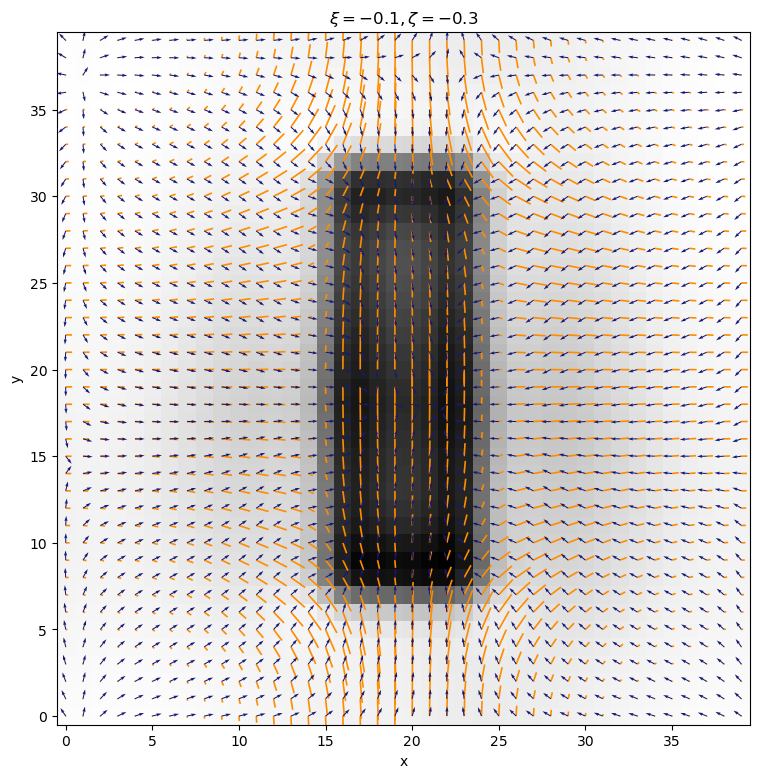

In [143]:
print(m.xi, m.zeta)
vx, vy, tension = list(zip(*m.v))
tension = np.array(tension)
vs = np.stack([vx, vy], axis=-1)
t_trace = np.einsum('ijkll->ijk', tension)
tQ = tension[:, :, :, 0, 0] - t_trace/2 
tq = tension[:, :, :, 1, 0]

t = -1
v = vs[t] 
print(v.shape)
v_hat = v/np.sqrt(np.sum(v**2, axis=-1))[:, :, np.newaxis]
Qx, Qy = nematic_to_xy(m.Q[t].T, m.q[t].T)
norm = np.sqrt(Qx**2+Qy**2)

plt.figure(figsize=(14, 9))
plt.quiver(Qx, Qy, headlength=0, headwidth=0, headaxislength=0, color='darkorange')
plt.quiver(v_hat[:, :, 0].T, v_hat[:, :, 1].T, color='midnightblue', width=0.0015)
plt.imshow(m.rho[t].T, origin='lower', cmap='Greys')
plt.title(r'$\xi ={{{}}}, \zeta={{{}}}$'.format(xi, zeta))
plt.xlabel('x')
plt.ylabel('y')
plt.show()
plt.close() 

In [144]:
vx, vy, tension = list(zip(*m.v))
tension = np.array(tension)
vs = np.stack([vx, vy], axis=-1)
t_trace = np.einsum('ijkll->ijk', tension)
tQ = tension[:, :, :, 0, 0] - t_trace/2 
tq = tension[:, :, :, 1, 0]

(40, 40, 2)


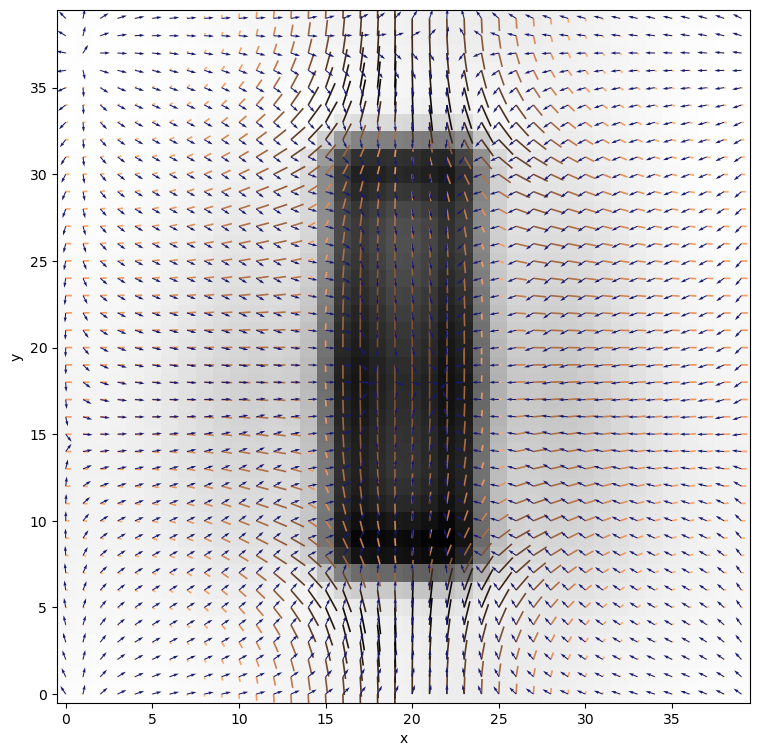

In [146]:
t = -1
v = vs[t] 
print(v.shape)
v_hat = v/np.sqrt(np.sum(v**2, axis=-1))[:, :, np.newaxis]
Qx, Qy = nematic_to_xy(m.Q[t].T, m.q[t].T)
norm = np.sqrt(Qx**2+Qy**2)

plt.figure(figsize=(14, 9))
plt.quiver(Qx, Qy, norm, cmap='copper_r', headlength=0, headwidth=0, headaxislength=0)
plt.quiver(v_hat[:, :, 0].T, v_hat[:, :, 1].T, color='midnightblue', width=0.0015)
plt.imshow(m.rho[t].T, origin='lower', cmap='Greys')
plt.xlabel('x')
plt.ylabel('y')
plt.show()
plt.close() 

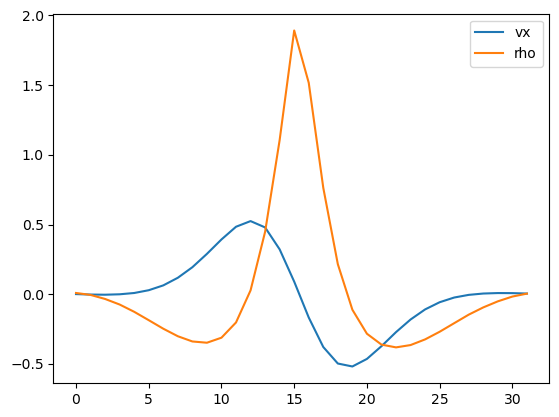

In [26]:
plt.close() 
plt.plot(vs[-1, :, 16, 0], label='vx')
plt.plot(m.rho[-1, :, 16]-1, label='rho')
plt.legend() 
plt.show() 

In [10]:
def make_movie(rhos, Qs, qs, vs):
    fig, ax = plt.subplots(1, 2, figsize=(15, 6))
  
    vmin = np.amin(rhos)
    vmax = np.amax(rhos)
    Qx, Qy = nematic_to_xy(Qs[-1].T, qs[-1].T)
    
    p1 = ax[0].imshow(rhos[0].T, vmin=vmin, vmax=vmax, cmap='Greys')
    fig.colorbar(p1, ax=ax[0], shrink=0.8)
    ax[0].axis('off')
    
    
    p2 = ax[1].quiver(Qx, Qy, headlength=0, headwidth=0, headaxislength=0)
    ax[1].axis('off')
    
    panels = [p1, p2]
    
    def animate(i): 

        panels[0].set_data(rhos[i].T)
        Qx, Qy = nematic_to_xy(Qs[i].T, qs[i].T)
        panels[1].set_UVC(Qx, Qy)
        return panels

    ani = animation.FuncAnimation(fig, animate, interval=50, blit=True,
                                    repeat_delay=1000, frames=rhos.shape[0])
    plt.show() 
    return ani 


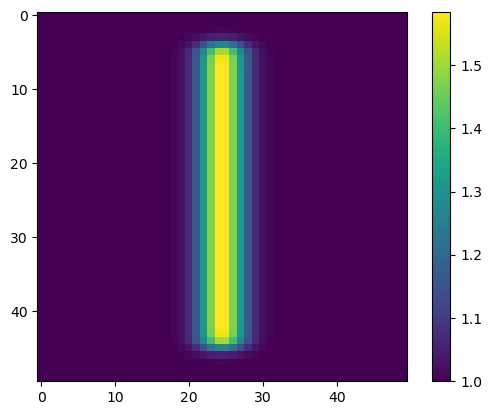

In [70]:
plt.imshow(source(T).T)
plt.colorbar() 
plt.show() 